In [138]:
import os
import os.path as osp
from glob import glob
import cv2
import csv
import pandas as pd
import natsort
import numpy as np
from itertools import chain
import json
import pickle
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter   
from PIL import Image
from tqdm import tqdm
import shutil

In [139]:
with open('/opt/ml/final-project-level3-cv-04/result/0lXwMdnpoFQ/60/csv/pred.pickle', mode='rb') as f:
    pred = pickle.load(f)

with open('/opt/ml/final-project-level3-cv-04/result/0lXwMdnpoFQ/60/csv/df1_face.pickle', mode='rb') as f:
    df1 = pickle.load(f)

with open('/opt/ml/final-project-level3-cv-04/result/0lXwMdnpoFQ/60/0lXwMdnpoFQ.json', mode='r') as f:
    meta_info = json.load(f)

In [140]:
#### clansing
def clansing(df:pd.DataFrame, pred:dict) -> pd.DataFrame:
    # drop useless column
    df.drop(['det_body_xmin', 
             'det_body_ymin', 
             'det_body_xmax',
             'det_body_ymax',
             'det_conf',
             'track_body_xmin',
             'track_body_ymin',
             'track_body_xmax',
             'track_body_ymax',
             'track_conf',
             'num_overlap_bboxes',
             'intercept_iou',
             'isfront',
             'face_bbox',
             'face_embedding',
             'face_confidence'], axis=1, inplace=True)

    # track_id type change
    df['track_id'] = df['track_id'].astype('int32')

    # assign name
    for k,v in pred.items():
        df.loc[df['track_id']==k,'name'] = v

    return df


#### get face order
def get_order(element, lst):
    try:
        return lst.index(element)
    except ValueError:
        return -1


#### for key point assign
def get_keypoint(element, idx):
    if idx != -1:
        left_eye_point = element[idx][0]
        right_eye_point = element[idx][1]
        center_point = [int((x + y)/2) for x, y in zip(left_eye_point, right_eye_point)]
        return center_point
    else: # if un detected keypoints return [-1,-1]
        return [-1, -1]


#### add bbox column
def keypoint_center_bounding_box(coord, crop_width, crop_height):
    x, y = coord
    if x==-1 or y==-1: # if undetected keypoints [-1,-1]
        return [-1,-1,-1,-1]
    x_min = x - crop_width / 2
    y_min = y - crop_height / 2
    x_max = x + crop_width / 2
    y_max = y + crop_height / 2
    coordinate = [int(i) for i in [x_min, y_min, x_max, y_max]] # int coordinate
    return coordinate


#### add shift bbox column
def shift_bounding_box(bbox, shift_ratio, meta_info):
    x_min, y_min, x_max, y_max = bbox
    if x_min == -1 or y_min == -1 or x_max == -1 or y_max == -1:
        return [0,0,meta_info['width'],meta_info['height']]
        # return np.nan
    
    height = y_max - y_min
    y_min += height * shift_ratio
    y_max += height * shift_ratio
    coordinate = [int(i) for i in [x_min, y_min, x_max, y_max]]
    return coordinate


#### add clip coords
def clip_coords(df, x_range, y_range):
    # clip
    df['cliped_bbox'] = df['shift_bbox'].apply(lambda x: [min(x_range[1], max(x_range[0], x[0])),
                                                min(y_range[1], max(y_range[0], x[1])),
                                                min(x_range[1], max(x_range[0], x[2])),
                                                min(y_range[1], max(y_range[0], x[3]))])
    # add cliped column
    df['isclip']  = df['cliped_bbox'] != df['shift_bbox']
    return df


#### add missing rows
def add_missing_files(df, all_files, name, meta_info):
    missing_files = set(all_files) - set(df['filename'])
    if missing_files:
        missing_df = pd.DataFrame({
                                    'frame':[int(filename.split('.')[0]) for filename in list(missing_files)],
                                    'filename': list(missing_files), 
                                    'name': [name for i in list(missing_files)],
                                    'shift_bbox': [[0,0,meta_info['width'],meta_info['height']] for i in list(missing_files)],
                                    # 'isclip': [False for i in list(missing_files)]
                                    })
        df = df.append(missing_df, ignore_index=True)

    df = df.sort_values(by='frame' ,ascending=True)
    df.reset_index(inplace=True, drop=True)
    return df


#### Define a function to collect the values of columns A, B, C, and D as a list
def collect_values(row):
    return [row['xmin'], row['ymin'], row['xmax'], row['ymax']]


#### tagging untrack frame
def tagging_untrack_frame(row, meta_info):
    if row == [0, 0, meta_info['width'], meta_info['height']]:
        return False
    else:
        return True


#### smoothing
def smoothing(df):
    # split coordinates
    df['xmin'] = [coordinate[0] for coordinate in df['shift_bbox']]
    df['ymin'] = [coordinate[1] for coordinate in df['shift_bbox']]
    df['xmax'] = [coordinate[2] for coordinate in df['shift_bbox']]
    df['ymax'] = [coordinate[3] for coordinate in df['shift_bbox']]
    
    df['xmin'] = df[['xmin']].apply(savgol_filter,  window_length=45, polyorder=2)
    df['ymin'] = df[['ymin']].apply(savgol_filter,  window_length=45, polyorder=2)
    df['xmax'] = df[['xmax']].apply(savgol_filter,  window_length=45, polyorder=2)
    df['ymax'] = df[['ymax']].apply(savgol_filter,  window_length=45, polyorder=2)

    df['xmin'] = df['xmin'].astype('int')
    df['ymin'] = df['ymin'].astype('int')
    df['xmax'] = df['xmax'].astype('int')
    df['ymax'] = df['ymax'].astype('int')

    df['smoothed_bbox'] = df.apply(collect_values, axis=1)

    return df


def trim(df):
    # drop useless column
    df.drop(['face_keypoint', 
             'face_pred', 
             'key_point_order',
             'center_point',
            #  'xmin',
            #  'ymin',
            #  'xmax',
            #  'ymax'
            ], axis=1, inplace=True)
    return df



# top, bottom, left, right ; 경계의 각 방향에 대한 선의 폭
def img_padding(img, xmin, ymin, xmax, ymax, w, h):   # img 사이즈 범위 밖으로 벗어나면 그에맞게 padding
    # xmin, ymin, xmax, ymax
    if xmax>w:
        img = cv2.copyMakeBorder(img, 0, 0, 0, xmax-w, cv2.BORDER_CONSTANT) # right xmax-w add pixel
    
    if xmin<0: # xmin is minus
        img = cv2.copyMakeBorder(img, 0, 0,-xmin, 0, cv2.BORDER_CONSTANT) # left -xmin add pixel
        xmax = xmax - xmin # 1024-(-125)
        xmin = 0
    
    if ymax>h:
        img = cv2.copyMakeBorder(img, 0, ymax-h, 0, 0, cv2.BORDER_CONSTANT) # bottom ymax-h add pixel
    
    if ymin<0:
        img = cv2.copyMakeBorder(img, -ymin, 0, 0, 0, cv2.BORDER_CONSTANT) # bottom ymax-h add pixel
        py = ymax - ymin
        ymin = 0
    
    return img, xmin, ymin, xmax, ymax


def change_short_time_undetect_bbox(df, fps):
    values = np.array(df['is_track'].tolist())
    run_sum = np.cumsum(values)
    for n in set(run_sum):
        indices = np.where(run_sum == n)
        indices = indices[0].tolist()
        if len(indices) <= fps:

            start_bbox_coord = df.iloc[indices[0]]['smoothed_bbox']

            for idx in indices:
                df.at[idx,'smoothed_bbox'] = start_bbox_coord
    return df

def moving_avg_untrackrow(df, keep_threshold):
    df['increase_decrease_bbox'] = [None] * len(df)
    df.at[0, 'increase_decrease_bbox'] = df.at[0, 'shift_bbox']

    cnt=0
    last_state=None
    df['is_track_update'] = [False]*len(df)

    for i in range(1, len(df)):
        # if untrack case
        if df.at[i, 'shift_bbox'] == [0,0,2880,2160] and df.at[i, 'is_track'] == False:
            # increase cnt
            cnt+=1
            if i > 0 and i < len(df) - 1:
                # calculate the average of the previous and next values for each component of shift_bbox
                xmin = int((df.at[i-1, 'shift_bbox'][0] + df.at[i+1, 'shift_bbox'][0]) / 2)
                ymin = int((df.at[i-1, 'shift_bbox'][1] + df.at[i+1, 'shift_bbox'][1]) / 2)
                xmax = int((df.at[i-1, 'shift_bbox'][2] + df.at[i+1, 'shift_bbox'][2]) / 2)
                ymax = int((df.at[i-1, 'shift_bbox'][3] + df.at[i+1, 'shift_bbox'][3]) / 2)
                # update the values of shift_bbox in the current row
                df.at[i, 'increase_decrease_bbox'] = [xmin, ymin, xmax, ymax]
                # update state
            elif i == 0:
                # if the current row is the first row, take the value of the next row
                df.at[i, 'increase_decrease_bbox'] = df.at[i+1, 'shift_bbox']
            else:
                # if the current row is the last row, take the value of the previous row
                df.at[i, 'increase_decrease_bbox'] = df.at[i-1, 'shift_bbox']
            # df.at[i, 'is_track_update'] = True
        
        # if tracked appeared
        else:
            # if under_threshold replace last state
            # df.at[i, 'is_track_update'] = False
            
            # update short track_state
            if 0<cnt<keep_threshold:
                for j in range(cnt):
                    target_idx = i-(j+1)
                    df.at[target_idx, 'increase_decrease_bbox'] = last_state
                    df.at[target_idx, 'is_track_update'] = True # if short time state update
            
            cnt=0
            df.at[i, 'increase_decrease_bbox'] = df.at[i, 'shift_bbox']
            last_state=df.at[i, 'shift_bbox']
    df['need_padding'] = df['is_track'] | df['is_track_update']
    return df


def crop_resize_save_img(df, img_dir_path, save_dir, name, meta_info, target_col, window_height, window_width):
    print(f'{target_col}')
    mini_df = df[['filename', target_col, 'need_padding']]
    cnt=0
    width = meta_info['width']
    height = meta_info['height']
    padded_box = []

    # mini_df['need_padding'] = mini_df['is_track'] | mini_df['is_track_update']

    # make dir
    dir_path = osp.join(save_dir, name)
    os.makedirs(dir_path, exist_ok=True)

    print(f"start cropping {len(df)} images.")
    for order, (index, row) in tqdm(enumerate(mini_df.iterrows())):
        # load
        img = cv2.imread(osp.join(img_dir_path, row['filename']))
        # get bbox coordinate
        xmin, ymin, xmax, ymax = row[target_col][0], row[target_col][1], row[target_col][2], row[target_col][3]
        if row['need_padding']: # tracked
            # get center-point
            center_y, center_x = (ymin+ymax)//2, (xmin+xmax)//2
            # get new xmin, ymin, xmax, ymax
            xmin, ymin, xmax, ymax = center_x-window_width//2, center_y-window_height//2, center_x+window_width//2, center_y+window_height//2
            # if over range, padding around
            if xmax>width or xmin<0 or ymax>height or ymin<0:
                img, xmin, ymin, xmax, ymax = img_padding(img, xmin, ymin, xmax, ymax, width, height)
            # crop
            img = img[ymin:ymax, xmin:xmax]
        else: # untracked, just resize
            img = cv2.resize(img, dsize=(window_width, window_height), interpolation=cv2.INTER_CUBIC)
        # append
        padded_box.append([xmin, ymin, xmax, ymax])
        # if unmatching window img print size
        if img.shape[0] != window_height and img.shape[1] != window_width:
            print(img.shape[0], window_height, img.shape[1], window_width)
        # write img
        cv2.imwrite(osp.join(dir_path, row['filename']), img)
    df['padded_box'] = padded_box
    return df, dir_path


def make_video(dir_path, meta_info, save_dir, window_height, window_width, name):
    files = os.listdir(dir_path)
    img_list = natsort.natsorted(files)
    img_paths = [osp.join(dir_path, i) for i in img_list]
    video_path = osp.join(save_dir, f'{name}_output.mp4')
    out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), meta_info['fps'], (window_width, window_height))
    
    print(f"{name}'s video recoding...")
    for path in tqdm(img_paths):
        img = cv2.imread(path)
        out.write(img)
    out.release()
    
    return video_path



def video_gen(df:pd.DataFrame, meta_info:dict, member:str, pred:dict,  save_dir:str,
             window_ratio:float, aespect_ratio:float, shift_bb:float):

    view_type = None

    # check aespect ratio Type and assign view_type
    if aespect_ratio >= 1:
        view_type = 'horizontal'
    else:
        view_type = 'vertical'

    # calc window
    window_height = int(meta_info['height']*window_ratio)
    window_width = int(meta_info['width']*window_ratio)

    # 1. clansing df
    df = clansing(df, pred)
    
    # 2. assign key_point order
    df['key_point_order'] = df.apply(lambda x: get_order(x['name'], x['face_pred']), axis=1)

    # 3. get center point(int type)
    df1['center_point'] = df1.apply(lambda x: get_keypoint(x['face_keypoint'], x['key_point_order']), axis=1)

    # 4. get center_bbox(bbox center is key_point)
    df['center_bbox'] = df['center_point'].apply(lambda x: keypoint_center_bounding_box(x, window_height, window_width))

    # 5. shifting bbox, if undetected keypoints or unmatching preds bbox is full
    df['shift_bbox'] = df['center_bbox'].apply(lambda x: shift_bounding_box(x, shift_bb, meta_info))
    
    # clip and add isclip column
    # df = clip_coords(df, (0, meta_info['width']), (0,meta_info['height']))

    # 7. sorting selected member
    df = df[df['name'] == member]

    # 8. get all captures img filenames
    img_dir_path = meta_info['image_root'].replace('.','..') # change for current path
    img_files = os.listdir(img_dir_path)

    # 9. add missing rows
    df = add_missing_files(df, img_files, member, meta_info)

    # 10. tagging untracked frame
    df['is_track'] = df['shift_bbox'].apply(lambda x: tagging_untrack_frame(x, meta_info))
    
    # 12. trim
    df = trim(df)

    # 11. moving avg untrack row
    df = moving_avg_untrackrow(df, keep_threshold=meta_info['fps']//2)

    # 13. clip img for over bbox, if long untracked frame made by resume
    df, crop_img_path = crop_resize_save_img(df, img_dir_path, save_dir, member, meta_info, 'increase_decrease_bbox', window_height, window_width)
    
    # 14. making video
    make_video(crop_img_path, meta_info, save_dir, window_height, window_width, member)
    
    # 15. delete crop imgs
    shutil.rmtree(crop_img_path)
    
    return df

In [141]:
video_gen(df1,  meta_info, 'aespa_karina', pred, './', window_ratio=0.4, aespect_ratio=1, shift_bb=0.1).to_csv('result.csv') # asepect_ratio = width/height

increase_decrease_bbox
start cropping 1440 images.


1440it [01:45, 13.63it/s]


aespa_karina's video recoding...


100%|██████████| 1440/1440 [00:32<00:00, 43.77it/s]


In [964]:
df[['is_track','smoothed_bbox']]
# df

,is_track,smoothed_bbox
0,True,"[1873, 184, 2737, 1336]"
1,True,"[1870, 185, 2734, 1337]"
2,True,"[1868, 185, 2732, 1337]"
3,True,"[1867, 186, 2731, 1338]"
4,True,"[1865, 186, 2729, 1338]"
...,...,...
1435,False,"[0, 0, 2880, 2160]"
1436,False,"[0, 0, 2880, 2160]"
1437,False,"[0, 0, 2880, 2160]"
1438,False,"[0, 0, 2880, 2160]"


In [85]:
import pandas as pd

# create the sample data frame
df = pd.DataFrame({'shift_bbox': [[0,0,2880,2160], #1
                                  [100,200,300,400], #2
                                  [200,100,400,300], #3
                                  [0,0,2880,2160], #4
                                  [0,0,2880,2160], #5
                                  [0,0,2880,2160], #6
                                  [200,100,400,300], #7
                                  [0,0,2880,2160], #8
                                  [0,0,2880,2160], #9
                                  [100,200,300,400], #10
                                  [200,100,400,300], #11
                                  [0,0,2880,2160], #12
                                  [0,0,2880,2160], #13
                                  [100,200,300,400], #14
                                  [0,0,2880,2160]], #15
                    'is_track': [False, #1
                                 True, #2
                                 True, #3
                                 False, #4
                                 False, #5
                                 False, #6
                                 True, #7
                                 False, #8
                                 False, #9
                                 True, #10
                                 True, #11
                                 False, #12
                                 False, #13
                                 True, #14
                                 False]}) #15 

print(df)
print('='*50)
df['increase_decrease_bbox'] = [None] * len(df)
df.at[0, 'increase_decrease_bbox'] = df.at[0, 'shift_bbox']
# iterate through each row in the data frame
cnt = 0
threshold = 3
last_state = None
for i in range(1, len(df)):
    # if the conditions are met
    if df.at[i, 'shift_bbox'] == [0,0,2880,2160] and df.at[i, 'is_track'] == False:
        # increase cnt
        cnt+=1

        if i > 0 and i < len(df) - 1:
            # calculate the average of the previous and next values for each component of shift_bbox
            xmin = (df.at[i-1, 'shift_bbox'][0] + df.at[i+1, 'shift_bbox'][0]) / 2
            ymin = (df.at[i-1, 'shift_bbox'][1] + df.at[i+1, 'shift_bbox'][1]) / 2
            xmax = (df.at[i-1, 'shift_bbox'][2] + df.at[i+1, 'shift_bbox'][2]) / 2
            ymax = (df.at[i-1, 'shift_bbox'][3] + df.at[i+1, 'shift_bbox'][3]) / 2
            # update the values of shift_bbox in the current row
            df.at[i, 'increase_decrease_bbox'] = [xmin, ymin, xmax, ymax]
        elif i == 0:
            # if the current row is the first row, take the value of the next row
            df.at[i, 'increase_decrease_bbox'] = df.at[i+1, 'shift_bbox']
        else:
            # if the current row is the last row, take the value of the previous row
            df.at[i, 'increase_decrease_bbox'] = df.at[i-1, 'shift_bbox']
    
    else:
        if 0<cnt<threshold: # if threshold under
            print(i, cnt, df.at[i, 'shift_bbox'])
            for j in range(cnt):
                target_idx = i-(j+1)
                # print('target_idx', target_idx, last_state)
                df.at[target_idx, 'increase_decrease_bbox'] = last_state

        # reset cnt
        cnt=0
        df.at[i, 'increase_decrease_bbox'] = df.at[i, 'shift_bbox']
        last_state = df.at[i, 'shift_bbox']
        

# display the updated data frame
print(df)


              shift_bbox  is_track
0     [0, 0, 2880, 2160]     False
1   [100, 200, 300, 400]      True
2   [200, 100, 400, 300]      True
3     [0, 0, 2880, 2160]     False
4     [0, 0, 2880, 2160]     False
5     [0, 0, 2880, 2160]     False
6   [200, 100, 400, 300]      True
7     [0, 0, 2880, 2160]     False
8     [0, 0, 2880, 2160]     False
9   [100, 200, 300, 400]      True
10  [200, 100, 400, 300]      True
11    [0, 0, 2880, 2160]     False
12    [0, 0, 2880, 2160]     False
13  [100, 200, 300, 400]      True
14    [0, 0, 2880, 2160]     False
9 2 [100, 200, 300, 400]
13 2 [100, 200, 300, 400]
              shift_bbox  is_track         increase_decrease_bbox
0     [0, 0, 2880, 2160]     False             [0, 0, 2880, 2160]
1   [100, 200, 300, 400]      True           [100, 200, 300, 400]
2   [200, 100, 400, 300]      True           [200, 100, 400, 300]
3     [0, 0, 2880, 2160]     False  [100.0, 50.0, 1640.0, 1230.0]
4     [0, 0, 2880, 2160]     False     [0.0, 0.0, 2880.0, 2

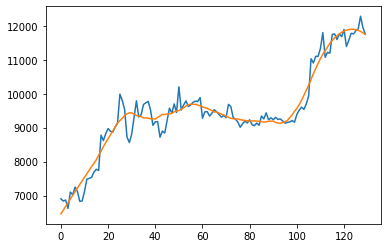

In [778]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter    

# noisy data
x = [6903.79, 6838.04, 6868.57, 6621.25, 7101.99, 7026.78, 7248.6, 7121.4, 6828.98, 6841.36, 7125.12, 7483.96, 7505.0, 7539.03, 7693.1, 7773.51, 7738.58, 8778.58, 8620.0, 8825.67, 8972.58, 8894.15, 8871.92, 9021.36, 9143.4, 9986.3, 9800.02, 9539.1, 8722.77, 8562.04, 8810.99, 9309.35, 9791.97, 9315.96, 9380.81, 9681.11, 9733.93, 9775.13, 9511.43, 9067.51, 9170.0, 9179.01, 8718.14, 8900.35, 8841.0, 9204.07, 9575.87, 9426.6, 9697.72, 9448.27, 10202.71, 9518.02, 9666.32, 9788.14, 9621.17, 9666.85, 9746.99, 9782.0, 9772.44, 9885.22, 9278.88, 9464.96, 9473.34, 9342.1, 9426.05, 9526.97, 9465.13, 9386.32, 9310.23, 9358.95, 9294.69, 9685.69, 9624.33, 9298.33, 9249.49, 9162.21, 9012.0, 9116.16, 9192.93, 9138.08, 9231.99, 9086.54, 9057.79, 9135.0, 9069.41, 9342.47, 9257.4, 9436.06, 9232.42, 9288.34, 9234.02, 9303.31, 9242.61, 9255.85, 9197.6, 9133.72, 9154.31, 9170.3, 9208.99, 9160.78, 9390.0, 9518.16, 9603.27, 9538.1, 9700.42, 9931.54, 11029.96, 10906.27, 11100.52, 11099.79, 11335.46, 11801.17, 11071.36, 11219.68, 11191.99, 11744.91, 11762.47, 11594.36, 11761.02, 11681.69, 11892.9, 11392.09, 11564.34, 11779.77, 11760.55, 11852.4, 11910.99, 12281.15, 11945.1, 11754.38]

df = pd.DataFrame(dict(x=x))
x_filtered = df[["x"]].apply(savgol_filter,  window_length=31, polyorder=2)

plt.ion()
plt.plot(x)
plt.plot(x_filtered)
plt.show()